# Poisson Regression in Statsmodels and TensorFlow Probability
Author: Matt McDonnell (@mattmcd)  

Date: 2023-09-12

Comparison between the [statsmodels](https://www.statsmodels.org/stable/index.html), [TensorFlow Probability GLM](https://www.tensorflow.org/probability/api_docs/python/tfp/glm), and [TensorFlow Probability Distribution Lambda](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda) APIs.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from startup import np, pd, plt, sns
from startup_gui import interact, interactive, widgets

In [3]:
import scipy
import sympy as sp

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp

2023-09-13 08:11:44.592 Python[5414:42893] apply_selection_policy_once: avoid use of removable GPUs (via org.python.python:GPUSelectionPolicy->avoidRemovable)


In [6]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

In [7]:
tfd = tfp.distributions

In [8]:
rng = np.random.default_rng(seed=42)

# Creating Poisson Distribution

In [9]:
def create_dataset(dist_mean, n_sample=10_000):
    df = pd.DataFrame(
        {
            'response': rng.poisson(dist_mean, n_sample).astype(np.float32),  # Response variable
            'Intercept': np.ones((n_sample, ), dtype=np.float32)  # Explanatory variable - just the intercept
        }
    )
    return df

In [10]:
def show_dist(df):
    display(df.describe())
    df.response.hist(bins=np.arange(0, 41), figsize=(4,2))

## GUI

In [11]:
_ = interact(lambda dist_mean: show_dist(create_dataset(dist_mean)), dist_mean=widgets.IntSlider(10, min=1, max=20))

interactive(children=(IntSlider(value=10, description='dist_mean', max=20, min=1), Output()), _dom_classes=('w…

# Fitting Poisson Distribution Using statsmodels

In [12]:
def create_statsmodel(df):
    return smf.glm('response ~ 1', data=df, family=sm.families.Poisson())

In [13]:
def fit_statsmodel(df):
    mdl = create_statsmodel(df).fit()
    show_dist(df)
    display(mdl.summary())
    print(f'Fit distribution mean = exp(Intercept) = {np.exp(mdl.params.Intercept).round(2)}')

## GUI

In [14]:
_ = interact(lambda dist_mean: fit_statsmodel(create_dataset(dist_mean)), dist_mean=widgets.IntSlider(10, min=1, max=20))

interactive(children=(IntSlider(value=10, description='dist_mean', max=20, min=1), Output()), _dom_classes=('w…

# Fitting Poisson Distribution using TensorFlow Probability GLM
Direct replacement for statsmodels GLM, see [TFP Generalized Linear Models](https://www.tensorflow.org/probability/examples/Generalized_Linear_Models) examples documentation.

In [15]:
def create_tfp_glm_model():
    return tfp.glm.Poisson()

In [16]:
def fit_tfp_glm_model(model, df):
    coeffs, linear_response, is_converged, num_iter = tfp.glm.fit(
    model_matrix=df.Intercept.values[:, tf.newaxis],
    response=tf.cast(df.response.values, dtype=tf.float32),
    model=model_glm)
    return coeffs, linear_response

In [17]:
model_glm = create_tfp_glm_model()

In [18]:
coeffs, linear_response = fit_tfp_glm_model(model_glm, create_dataset(10))

In [19]:
coeffs

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.3032646], dtype=float32)>

In [20]:
np.mean(linear_response)

2.3032646

In [21]:
model_glm.as_distribution(linear_response).sample()

2023-09-13 08:11:45.938503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:45.943339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:45.975376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:45.984290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([ 7.,  6.,  8., ...,  8., 14.,  7.], dtype=float32)>

## GUI

In [22]:
def fit_display_tfp_glm(df):
    model_glm = create_tfp_glm_model()
    coeffs, linear_response = fit_tfp_glm_model(model_glm, df)
    # Sample predicted distribution
    sample_x = np.ones((1000, 1))
    sample_linear_response = (sample_x.dot(coeffs.numpy())).reshape(-1)
    df_p = pd.DataFrame({'response': model_glm.as_distribution(sample_linear_response).sample().numpy()})
    show_dist(df_p)
    print(f'Fit distribution mean = exp(Intercept) = {np.exp(coeffs[0]).round(2)}')

In [23]:
_ = interact(
    lambda dist_mean: print(
        'Fit distribution mean = exp(Intercept) = ' + 
       f'{np.exp(fit_tfp_glm_model(model_glm, create_dataset(dist_mean))[0][0]).round(2)}'
    ),
    dist_mean=widgets.IntSlider(10, min=1, max=20)
)

interactive(children=(IntSlider(value=10, description='dist_mean', max=20, min=1), Output()), _dom_classes=('w…

In [24]:
_ = interact(lambda dist_mean: fit_display_tfp_glm(create_dataset(dist_mean)), dist_mean=widgets.IntSlider(10, min=1, max=20))

interactive(children=(IntSlider(value=10, description='dist_mean', max=20, min=1), Output()), _dom_classes=('w…

# Fitting Poisson Distribution using TensorFlow Probability Distribution Lambda Layer
This is the most general form and can be used with any TFP-constructible distribution.  However it is slower than TFP GLM to fit because it uses generalized optimisation rather than Exponential Family-specific routines.

In [25]:
def create_tfp_layer_model():    
    def create_model():
        inputs = Input(shape=(1, ))
        rate = Dense(1, activation=tf.exp)(inputs)  # Note the exp link function
        p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate)
        model = Model(inputs=inputs, outputs=p_y)
        return model

    def NLL(y_true, y_hat):
        return -y_hat.log_prob(y_true)

    model = create_model()
    model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss=NLL)  # For Mac M1, use non-legacy otherwise
    return model

In [26]:
def fit_tfp_layer_model(model, df):
    model.fit(df.Intercept.values, df.response.values)

In [27]:
model_tfp = create_tfp_layer_model()

In [28]:
display(model_tfp.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

In [29]:
fit_tfp_layer_model(model_tfp, create_dataset(10))

 24/313 [=>............................] - ETA: 1s - loss: 13.7360

2023-09-13 08:11:47.278901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:47.282276: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


313/313 [==============================] - 2s 4ms/step - loss: 4.4678


Visualise by generating predictions from the distribution and plotting histogram 

 1/32 [..............................] - ETA: 5s

2023-09-13 08:11:48.721803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:48.728763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:48.766118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-09-13 08:11:48.774875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


32/32 [==============================] - 1s 31ms/step


array([[<Axes: title={'center': 'pred'}>]], dtype=object)

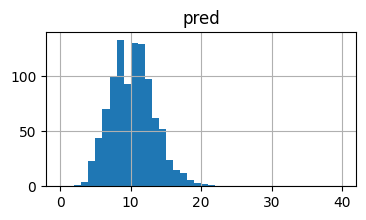

In [30]:
pd.DataFrame({'pred': model_tfp.predict(np.ones(1000)).reshape(-1)}).hist(bins=np.arange(0, 41), figsize=(4,2))